useful links:

- Data Preparation for Variable Length Input Sequences, URL: https://machinelearningmastery.com/data-preparation-variable-length-input-sequences-sequence-prediction/
- Masking and padding with Keras, URL: https://www.tensorflow.org/guide/keras/masking_and_padding
- Step-by-step understanding LSTM Autoencoder layers, URL: https://towardsdatascience.com/step-by-step-understanding-lstm-autoencoder-layers-ffab055b6352XX, 
- Understanding input_shape parameter in LSTM with Keras, URL: https://stats.stackexchange.com/questions/274478/understanding-input-shape-parameter-in-lstm-with-keras
- tf.convert_to_tensor, URL: https://www.tensorflow.org/api_docs/python/tf/convert_to_tensor
- ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type int) in Python, URL: https://datascience.stackexchange.com/questions/82440/valueerror-failed-to-convert-a-numpy-array-to-a-tensor-unsupported-object-type

In [1]:
"""
* Copyright 2020, Maestria de Humanidades Digitales,
* Universidad de Los Andes
*
* Developed for the Msc graduation project in Digital Humanities
*
* This program is free software: you can redistribute it and/or modify
* it under the terms of the GNU General Public License as published by
* the Free Software Foundation, either version 3 of the License, or
* (at your option) any later version.
*
* This program is distributed in the hope that it will be useful,
* but WITHOUT ANY WARRANTY; without even the implied warranty of
* MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
* GNU General Public License for more details.
*
* You should have received a copy of the GNU General Public License
* along with this program.  If not, see <http://www.gnu.org/licenses/>.
"""

# ===============================
# native python libraries
# ===============================
import re
import random
import json
import csv
import datetime
import copy
from collections import OrderedDict
from collections import Counter
from collections import deque

# ===============================
# extension python libraries
# ===============================
import pandas as pd
from pandas import ExcelWriter
from pandas import ExcelFile
import numpy as np
import matplotlib.pyplot as plt

# natural language processing packages
import gensim
from gensim import models
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

# downloading nlkt data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# sample handling sklearn package
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import make_scorer
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from skmultilearn.problem_transform import LabelPowerset
from skmultilearn.problem_transform import BinaryRelevance
from skmultilearn.problem_transform import ClassifierChain

# # Keras + Tensorflow ML libraries
from keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Masking
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import GlobalMaxPooling1D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import GlobalMaxPooling2D
from keras.optimizers import SGD

# ===============================
# developed python libraries
# ===============================

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Felipe\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Felipe\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Felipe\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
'''
A UDF to convert input data into 3-D
array as required for LSTM network.

taken from https://towardsdatascience.com/step-by-step-understanding-lstm-autoencoder-layers-ffab055b6352
'''
def temporalize(data, lookback):
    output_X = list()
    for i in range(len(X)-lookback-1):
        temp = list()
        for j in range(1,lookback+1):
            # Gather past records upto the lookback period
            temp.append(data[[(i+j+1)], :])
        temp = np.array(temp, dtype="object")
        output_X.append(temp)
    output_X = np.array(output_X, dtype="object")
    return output_X

In [7]:
# variable definitions
# root folder
dataf = "Data"

# subfolder with predictions txt data
targetf = "Target"

# report subfolder
reportf = "Reports"

#  subfolder with the CSV files containing the ML pandas dataframe
stdf = "Train"

# dataframe file extension
fext = "csv"

imgext = "jpg"

# dictionary extension
dext = "dict"

# standard sufix
stdprefix = "std-"

# ml model useful data
mltprefix = "ml-"

# report names
str_date = datetime.date.today().strftime("%d-%b-%Y")

small_sufix = "Text-Data-Small"
large_sufix = "Text-Data-Large"
painting_sufix = "Text-Data-Paintings"

gallery_prefix = "VVG-Gallery"

# dataframe file name
small_fn = stdprefix + gallery_prefix + "-" + small_sufix + "." + fext
large_fn = stdprefix + gallery_prefix + "-" + large_sufix + "." + fext
painting_fn = stdprefix + gallery_prefix + "-" + painting_sufix + "." + fext

# dictionary file name
sdict_fn = "VVG-Gallery-Text-Data-Small" + "." + dext
ldict_fn = "VVG-Gallery-Text-Data-Large" + "." + dext
pdict_fn = "VVG-Gallery-Text-Data-Paintings" + "." + dext

# ramdom seed
randseed = 42

# window size
min_wsize = 30
max_wsize = 60
def_wsize = int((min_wsize+max_wsize)/2)

# sample distribution train vs test sample size
trainf = 0.80
testf = 0.20

# regex to know that column Im interested in
keeper_regex = r"(^ID$)|(^std_)"

# default values
# work_fn, work_dict, work_sufix = small_fn, sdict_fn, small_sufix
# work_fn, work_dict, work_sufix = painting_fn, pdict_fn, painting_sufix
work_fn, work_dict, work_sufix = large_fn, ldict_fn, large_sufix

In [8]:
root_folder = os.getcwd()
root_folder = os.path.split(root_folder)[0]
root_folder = os.path.normpath(root_folder)
print(root_folder)

c:\Users\Felipe\Documents\GitHub\sa-artea\VVG-MLModel-Trainer


In [9]:
# variable reading
# dataframe filepath
fn_path = os.path.join(root_folder, dataf, stdf, work_fn)
print(fn_path)

# gensim dictionart filepath
dict_path = os.path.join(root_folder, dataf, stdf, work_dict)
print(dict_path)

c:\Users\Felipe\Documents\GitHub\sa-artea\VVG-MLModel-Trainer\Data\Train\std-VVG-Gallery-Text-Data-Large.csv
c:\Users\Felipe\Documents\GitHub\sa-artea\VVG-MLModel-Trainer\Data\Train\VVG-Gallery-Text-Data-Large.dict


In [10]:
# reading words dictionary
# loading gesim words dictionary
vvg_dict = gensim.corpora.Dictionary()
vvg_dict = vvg_dict.load(dict_path)
print(vvg_dict)

Dictionary(3962 unique tokens: ['1', '10', '1885', '1891', '1925']...)


In [11]:
# rading training data
# loading file
source_df = pd.read_csv(
                fn_path,
                sep=",",
                encoding="utf-8",
                engine="python",
            )

In [12]:
# checking everything is allrigth
source_df.head(5)
# chekcing the dataframe
source_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 929 entries, 0 to 928
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   ID                     929 non-null    object
 1   F-number               929 non-null    object
 2   JH-number              929 non-null    object
 3   creator-place          929 non-null    object
 4   creator-date           828 non-null    object
 5   details                929 non-null    object
 6   Dimensions             929 non-null    object
 7   MUS_TEXT               929 non-null    object
 8   std_cat_creator-date   929 non-null    object
 9   std_cat_creator-place  929 non-null    object
 10  std_cat_Dimensions     929 non-null    object
 11  std_cat_details        929 non-null    object
 12  clr_tokens             929 non-null    object
 13  lemmas                 929 non-null    object
 14  bows_tokens            929 non-null    object
 15  idxs_tokens            

In [13]:
# selecting data to train
# want to keep the columns starting with STD_
df_columns = list(source_df)
print("original input/interested columns:\n",  df_columns)
# create the columns Im interesting in
keep_columns = [i for i in df_columns if re.search(keeper_regex, i)]

print("\nInteresting columns:\n", keep_columns)

original input/interested columns:
 ['ID', 'F-number', 'JH-number', 'creator-place', 'creator-date', 'details', 'Dimensions', 'MUS_TEXT', 'std_cat_creator-date', 'std_cat_creator-place', 'std_cat_Dimensions', 'std_cat_details', 'clr_tokens', 'lemmas', 'bows_tokens', 'idxs_tokens', 'tfidf_tokens', 'std_dvec_tokens']

Interesting columns:
 ['ID', 'std_cat_creator-date', 'std_cat_creator-place', 'std_cat_Dimensions', 'std_cat_details', 'std_dvec_tokens']


In [14]:
# checking the number of max num on labels in the categories
too_disperse = list()
max_dis = 2
tcount = 0

while tcount < max_dis:
    for label_col in keep_columns:
        label_count = source_df[label_col].value_counts(normalize=False)

        if tcount < label_count.shape[0] and ("std_cat_" in label_col):
            tcount = label_count.shape[0]
            too_disperse.append(label_col)

        print("count values of", label_col, ":=", label_count.shape)#.__dict__)
    tcount = tcount + 1

print(too_disperse)

count values of ID := (929,)
count values of std_cat_creator-date := (180,)
count values of std_cat_creator-place := (21,)
count values of std_cat_Dimensions := (629,)
count values of std_cat_details := (113,)
count values of std_dvec_tokens := (778,)
['std_cat_creator-date', 'std_cat_Dimensions']


In [15]:
# creating the training dataframe
for too in too_disperse:
    keep_columns.remove(too)
# keep_columns.remove(too_disperse[0])
# keep_columns.remove("ID")
print("------ Interesting columns ------")
print(keep_columns)
train_df = pd.DataFrame(source_df, columns=keep_columns)

------ Interesting columns ------
['ID', 'std_cat_creator-place', 'std_cat_details', 'std_dvec_tokens']


In [16]:
# getting the column with the relevant data to train
dvector_col = [i for i in df_columns if re.search(u"^std_dvec", i)]
dvector_col = dvector_col[0]
print("Dense vector column in dataframe: ", str(dvector_col))

Dense vector column in dataframe:  std_dvec_tokens


In [17]:
# fix column data type
work_corpus = train_df[dvector_col]
dvec_std_corpus = list()

for dvector in work_corpus:
    dvector = eval(dvector)
    dvector = np.array(dvector)
    dvec_std_corpus.append(dvector)

dvec_std_corpus = np.array(dvec_std_corpus, dtype="object")

In [18]:
# changing type in dataframe
train_df[dvector_col] = dvec_std_corpus

In [19]:
# checking the train dataframe
train_df.head(5)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 929 entries, 0 to 928
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   ID                     929 non-null    object
 1   std_cat_creator-place  929 non-null    object
 2   std_cat_details        929 non-null    object
 3   std_dvec_tokens        929 non-null    object
dtypes: object(4)
memory usage: 29.2+ KB


In [20]:
# padding training data according to max length of text corpus
pad_prefix = "pad_"
recurrent_prefix = "lstm_"
padded_corpus = None

# getting the corpus dense vectors
dvec_std_corpus = train_df[dvector_col]

# converting list of list to array of array
print(dvec_std_corpus.shape)

# padding the representation
padded_corpus = pad_sequences(dvec_std_corpus, dtype='object', padding="post")
print(padded_corpus.shape)

# creating the new column and saving padded data
padded_col = pad_prefix + dvector_col

# print(padded_col)
train_df[padded_col] = list(padded_corpus)
print(padded_corpus.shape)

(929,)
(929, 276)
(929, 276)


In [21]:
# funct to concatenate all label columns into one for a single y in ML training, returns a list
def concat_labels(row, cname):
    ans = list()
    for c in cname:

        r = row[c]
        r = eval(r)
        ans = ans + r

    return ans

In [22]:
# getting the columns with the relevant labels to predict
print(keep_columns)
labels_cols = [i for i in keep_columns if re.search(u"^std_cat_", i)]
print("Trainable labels columns in dataframe: ", str(labels_cols))

labels_data = train_df[labels_cols]
labels_concat = list()

# concatenating all category labels from dataframe
for index, row in labels_data.iterrows():
    # print(row.shape)
    row = concat_labels(row, labels_cols)
    # print(len(row))
    labels_concat.append(row)

['ID', 'std_cat_creator-place', 'std_cat_details', 'std_dvec_tokens']
Trainable labels columns in dataframe:  ['std_cat_creator-place', 'std_cat_details']


In [23]:
print(len(labels_concat[0]), type(labels_concat[0]))

134 <class 'list'>


In [24]:
# updating dataframe
tcat_label_col = "std_cat_labels"
train_df[tcat_label_col] = labels_concat

In [25]:
# checking the train dataframe
train_df.head(5)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 929 entries, 0 to 928
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   ID                     929 non-null    object
 1   std_cat_creator-place  929 non-null    object
 2   std_cat_details        929 non-null    object
 3   std_dvec_tokens        929 non-null    object
 4   pad_std_dvec_tokens    929 non-null    object
 5   std_cat_labels         929 non-null    object
dtypes: object(6)
memory usage: 43.7+ KB


In [26]:
# creating Train/Test sample
# getting the X, y to train, as is autoencoder both are the same
X = np.array([np.array(i, dtype="object") for i in train_df[padded_col]], dtype="object")
y = np.array([np.array(j, dtype="object") for j in train_df[tcat_label_col]], dtype="object")

# X = train_df[padded_col]
# y = train_df[padded_col]

print(X.shape)
print(y.shape)

(929, 276)
(929, 134)


In [27]:
# balancing classes to train
lstm_lp = LabelPowerset()
lstm_smote = RandomOverSampler(random_state = randseed)

Xt = X
yt = lstm_lp.transform(y.astype("int"))
X_b, y_b = lstm_smote.fit_resample(Xt, yt)
y_b = lstm_lp.inverse_transform(y_b)
y_b = y_b.toarray()

print("Balance X:", X_b.shape)
print("Balance y:", y_b.shape)

Balance X: (18326, 276)
Balance y: (18326, 134)


In [28]:
# creating Train/Test sample
# getting the X, y to train, as is autoencoder both are the same
X = X_b#np.array([np.array(i, dtype="object") for i in X_b], dtype="object")
y = y_b#np.array([np.array(j, dtype="object") for j in y_b], dtype="object")

# X = train_df[padded_col]
# y = train_df[padded_col]

print(X.shape)
print(y.shape)

(18326, 276)
(18326, 134)


In [29]:
print(type(X[0]))
print(type(X[0][0]))
print(X.shape)

<class 'numpy.ndarray'>
<class 'float'>
(18326, 276)


In [30]:
print(type(y[0]))
print(type(y[0][0]))
print(y.shape)

<class 'numpy.ndarray'>
<class 'numpy.int64'>
(18326, 134)


In [31]:
# timestep is the memory of what i read, this is the longest sentence I can remember in the short term
# neet to look for the best option, in small the max is 15
timesteps = 15

# features is the max length in the corpus, after padding!!!!
features = X.shape[1]
labels = y.shape[1]
print(timesteps, features, labels)

15 276 134


In [32]:
# preparation for reshape lstm model
Xt = temporalize(X, timesteps)
# yt = temporalize(y, timesteps)
yt = y

In [33]:
print(Xt.shape)
print(yt.shape)

(18310, 15, 1, 276)
(18326, 134)


In [34]:
# reshaping for LSTM model
X_lstm = Xt.reshape((Xt.shape[0], timesteps, features))
print(X_lstm.shape)
# y_lstm = yt.reshape((yt.shape[0], timesteps, labels))
y_lstm = yt[0:X_lstm.shape[0]]
print(y_lstm.shape)

(18310, 15, 276)
(18310, 134)


In [35]:
# creating the column for the reshape data according to LSTM
lstm_col = recurrent_prefix + dvector_col
print(lstm_col)

lstm_std_dvec_tokens


In [36]:
# data to numpy format
X_lstm = np.asarray(X_lstm).astype(np.float)
y_lstm = np.asarray(y_lstm).astype(np.float)
print(X_lstm.shape)
print(y_lstm.shape)

(18310, 15, 276)
(18310, 134)


In [37]:
# dividing according to train/test proportions
X_train, X_test, y_train, y_test = train_test_split(X_lstm, y_lstm, train_size = trainf, test_size = testf, random_state = randseed)

In [38]:
# checking shaped
print("training shape (X, y)")
print("X: ", X_train.shape, " y: ", y_train.shape)

print("testing shape (X, y)")
print("X: ", X_test.shape, " y: ", y_test.shape)

print("data types")
print(type(X_train), type(X_test), type(y_train), type(y_test))
print(type(X_train[0]), type(X_test[0]), type(y_train[0]), type(y_test[0]))
print(type(X_train[0][0]), type(X_test[0][0]), type(y_train[0][0]), type(y_test[0][0]))
print(type(X_train[0][0][0]), type(X_test[0][0][0]), type(y_train[0][0]), type(y_test[0][0]))

training shape (X, y)
X:  (14648, 15, 276)  y:  (14648, 134)
testing shape (X, y)
X:  (3662, 15, 276)  y:  (3662, 134)
data types
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.float64'> <class 'numpy.float64'>
<class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.float64'>


In [39]:
Xtf_train = tf.convert_to_tensor(X_train, dtype="float64")
Xtf_test = tf.convert_to_tensor(X_test, dtype="float64")
ytf_train = tf.convert_to_tensor(y_train, dtype="float64")
ytf_test = tf.convert_to_tensor(y_test, dtype="float64")

# y_tensor = tf.convert_to_tensor(y, dtype=tf.float23) 

In [40]:
# number of neurons or processing units in LSTM
# the number is because of good practices for NLP
# min 200 max 500, normaly 300 (related to the semantic number of themes)
# 120 for now in this test
lstm_units = 400

# timestep is 1 because you read a word at a time
memory = timesteps
print("LSTM memory span:", memory)

# features is the max length in the corpus, after padding!!!!
features = X_train.shape[2]
print("LSTM learning features:", features)

# batch size
bs = int(X_train.shape[0]*0.01)
print("LSTM learning batch size:", bs)

print("LSMT processing units:", lstm_units)

# configuration to remember previous recurrent layer
rs = True

# neurons/processing units size in the dense layer (THIS SHOULD BE SOM!!!!)
dn1 = 32*32
print("Dense processing units:", dn1)
# dn2 = len(XB_set[0])*SECURITY_FACTOR

# numero de neuronas de salida
outn = y_train.shape[1]
print("Output prediction units:", outn)

# axtivation functions
inn = "relu"
act = "relu"
# act = "softmax"
out = "softmax"
# out = "sigmoid"
# out = "relu"

# loss percentage
ldrop = 0.2

# random seed
randseed = 42

# parameters to compile model
# loss function
ls = "binary_crossentropy"
# ls = "categorical_crossentropy"
# ls = "sparse_categorical_crossentropy"
# ls = "mean_squared_error"
# ls = "mean_absolute_error"
# ls = "cosine_similarity"

# optimization function
opti = "adam"
# opti = SGD(lr=0.01, momentum=0.9, decay=0.01)
# opti = "adagrad"
# opti = "RMSprop"

# evaluation score
met = ["accuracy"]

# parameters to exeute training
# verbose mode
ver = 1
# training epocha
epo = 500
print("training epochs:", epo)

LSTM memory span: 15
LSTM learning features: 276
LSTM learning batch size: 146
LSMT processing units: 400
Dense processing units: 1024
Output prediction units: 134
training epochs: 500


In [44]:
# model layers
# to avoid overfit you need to use dropout in someplaces
# options:
# 1) Mask -> Drop -> LSTM1 -> LSTM2 -> LSTM3 -> Drop -> Dense -> Drop -> LSTM3 -> LSTM2 -> LSTM1 -> Drop -> TimeDistDense
# 1) Mask -> Drop -> LSTM1 -> LSTM2 -> LSTM3 -> Dense -> LSTM3 -> LSTM2 -> LSTM1 -> Drop -> TimeDistDense
# 2) Mask -> Drop -> LSTM1 -> LSTM2 -> LSTM2 -> Dense -> LSTM2 -> LSTM2 -> LSTM1 -> Drop -> TimeDistDense
# 3) Mask -> Drop -> LSTM1 -> LSTM2 -> Drop -> Dense -> Drop -> LSTM2 -> LSTM1 -> Drop -> TimeDistDense
# 3) Mask -> Drop -> LSTM1 -> Drop -> Dense -> Drop -> STM1 -> Drop -> TimeDistDense
# 5) Mask -> Drop -> LSTM1 -> Drop -> Dense -> Drop -> LSTM1 -> TimeDistDense
lstm_layers = (

    # input layer (padding and prep)
    Masking(mask_value=0.0, input_shape=(memory, features), name = "LayMask"),

    # intermediate recurrent encoder layer
    LSTM(lstm_units, activation=inn, input_shape=(memory, features), return_sequences=rs, recurrent_dropout = ldrop, name = "EnLSTM_1"),
    # SpatialDropout1D(ldrop, name = "EnDrop_1"),
    Dropout(ldrop, name = "EnDrop_1"),

    # intermediate recurrent encoder layer
    LSTM(int(lstm_units/2), activation=inn, input_shape=(timesteps, features), return_sequences=rs, name = "EnLSTM_2"),
    # Dropout(ldrop, name = "EnDrop_2"),

    # intermediate recurrent encoder layer
    LSTM(int(lstm_units/4), activation=inn, input_shape=(timesteps, features), return_sequences=rs, name = "EnLSTM_3"),
    Dropout(ldrop, name = "EnDrop_3"),    

    # # intermediate recurrent encoder layer
    # LSTM(int(lstm_units/8), activation=inn, input_shape=(timesteps, features), return_sequences=False, name = "EnLSTM_4"),
    # SpatialDropout1D(ldrop, name = "EnDrop_4"),  
    # from 2D to 1D
    Flatten(name = "LayFlat1"),
    # Flatten(name = "LayFlat2"),

    # mid dense encoding layer
    # dense layer for abstraction (THIS SHOULD COULD SOM!!!!)    
    Dense(dn1, activation=act, name = "MidDense"),
    # Dropout(ldrop, name = "DeDrop_1"),
    # Flatten(name = "LyFlat1"),
    # Flatten(name = "LyFlat2"),

    # intermediate dense classification layer
    Dense(int(dn1/2), activation=act, name = "ClsDense_1"),
    Dropout(ldrop, name = "ClsDrop_1"),

    # intermediate dense classification layer
    Dense(int(dn1/4), activation=act, name = "ClsDense_2"),
    Dropout(ldrop, name = "ClsDrop_2"),

    # intermediate dense classification layer
    # Dense(int(dn1/8), activation=act, name = "ClsDense_3"),
    # Dropout(ldrop, name = "ClsDrop_3"),

    # output layer, dense time sequential layer.
    Dense(outn, activation=out, name = "LayClsOut"),
    # TimeDistributed(Dense(outn, activation=out), name = "LayClsOut"),
)

In [45]:
# defining model
lstm_model = Sequential(lstm_layers)
lstm_model.model_name = "LSTM_Classifier"

In [46]:
# compile model
lstm_model.compile(loss = ls, optimizer = opti, metrics = met)
lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
LayMask (Masking)            (None, 15, 276)           0         
_________________________________________________________________
EnLSTM_1 (LSTM)              (None, 15, 400)           1083200   
_________________________________________________________________
EnDrop_1 (Dropout)           (None, 15, 400)           0         
_________________________________________________________________
EnLSTM_2 (LSTM)              (None, 15, 200)           480800    
_________________________________________________________________
EnLSTM_3 (LSTM)              (None, 15, 100)           120400    
_________________________________________________________________
EnDrop_3 (Dropout)           (None, 15, 100)           0         
_________________________________________________________________
LayFlat1 (Flatten)           (None, 1500)             

In [47]:
# early stopping condition BECAAUSE THIS ARE TESTS
EarlyStopLSTM_Acc = EarlyStopping(monitor = "val_accuracy", min_delta = 0.01, patience = 20, verbose = 1, mode = "max", restore_best_weights = True)
EarlyStopLSTM_Loss = EarlyStopping(monitor = "val_loss", min_delta = 0.001, patience = 20, verbose = 1, mode = "max", restore_best_weights = True)


In [48]:
# training model
history_lstm = lstm_model.fit(
    x = Xtf_train, 
    y = ytf_train,
    epochs = epo, 
    verbose = ver, 
    workers = 6,
    batch_size = bs, 
    callbacks = [EarlyStopLSTM_Acc],#, EarlyStopLSTM_Loss],
    shuffle = False,
    use_multiprocessing = True,
    validation_data = (Xtf_test, ytf_test),
)

Epoch 1/500
101/101 [==============================] - 38s 311ms/step - loss: 0.1181 - accuracy: 0.1217 - val_loss: 0.0656 - val_accuracy: 0.1794
Epoch 2/500
101/101 [==============================] - 33s 326ms/step - loss: 0.0683 - accuracy: 0.1574 - val_loss: 0.0655 - val_accuracy: 0.1794
Epoch 3/500
101/101 [==============================] - 73s 723ms/step - loss: 0.0673 - accuracy: 0.1610 - val_loss: 0.0651 - val_accuracy: 0.1794
Epoch 4/500
101/101 [==============================] - 55s 542ms/step - loss: 0.0627 - accuracy: 0.1998 - val_loss: 0.0567 - val_accuracy: 0.2613
Epoch 5/500
101/101 [==============================] - 53s 528ms/step - loss: 0.0551 - accuracy: 0.3257 - val_loss: 0.0477 - val_accuracy: 0.4549
Epoch 6/500
101/101 [==============================] - 50s 499ms/step - loss: 0.0443 - accuracy: 0.5625 - val_loss: 0.0357 - val_accuracy: 0.6819
Epoch 7/500
101/101 [==============================] - 58s 576ms/step - loss: 0.0339 - accuracy: 0.6991 - val_loss: 0.0279 -

In [49]:
# evaluationg model
lstm_eval = lstm_model.evaluate(x = Xtf_test, y = ytf_test)

115/115 [==============================] - 5s 43ms/step - loss: 0.0180 - accuracy: 0.7619


In [50]:
# general evaluation 
print("avg loss: ", lstm_eval[0])
print("avg acc: ", lstm_eval[1])

avg loss:  0.018021637573838234
avg acc:  0.7618787288665771


In [51]:
# testing model
lstm_results = lstm_model.predict(X_test, batch_size = bs, verbose = 1)#, batch_size = bs)

26/26 [==============================] - 2s 46ms/step


In [52]:
lstm_results[0].shape

(134,)

In [53]:
# saving model
wdir = os.getcwd()
models_folder = "Models"
model_fname = "vvg_lstm_classifier"
model_fpn = os.path.join(root_folder, dataf, models_folder, model_fname)
print("The trained  model is:", model_fpn)
lstm_model.save(model_fpn)

The trained  model is: c:\Users\Felipe\Documents\GitHub\sa-artea\VVG-MLModel-Trainer\Data\Models\vvg_lstm_classifier
INFO:tensorflow:Assets written to: c:\Users\Felipe\Documents\GitHub\sa-artea\VVG-MLModel-Trainer\Data\Models\vvg_lstm_classifier\assets
INFO:tensorflow:Assets written to: c:\Users\Felipe\Documents\GitHub\sa-artea\VVG-MLModel-Trainer\Data\Models\vvg_lstm_classifier\assets


In [54]:
# cheking test shape
print(lstm_results.shape)

(3662, 134)


In [55]:
print(y_test[0].shape, "***************", lstm_results[0].shape)
# for y, r in zip(y_test, lstm_results):
#     print(len(y),  len(r))
#     r = r.round(2)
#     print(y, "\n", list(r))
    

(134,) *************** (134,)


<ipython-input-56-b662b269edfe>:21: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


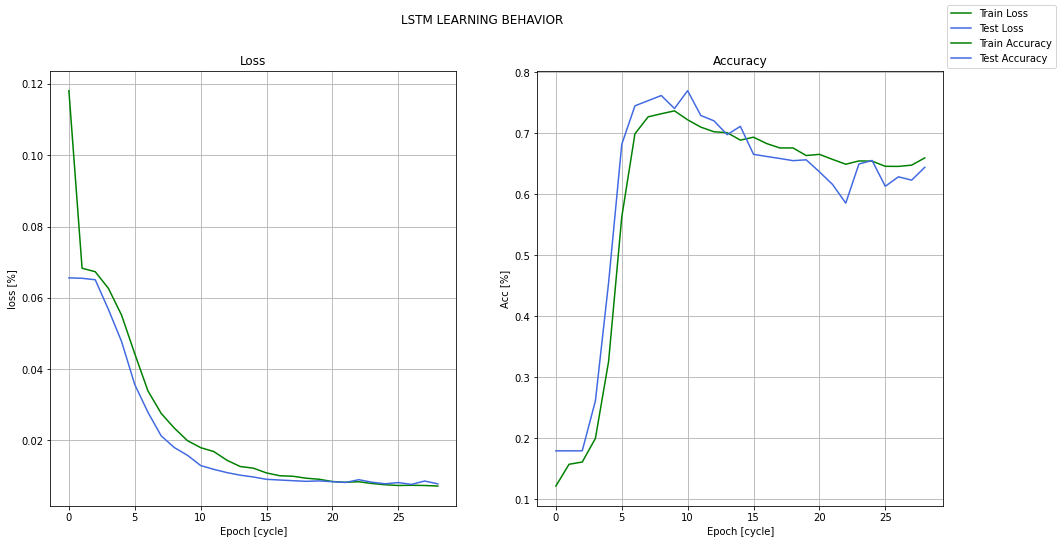

In [56]:
# reporting results
# reporte de entrenamiento para el modelo
# base de la figura
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,8))

# datos de la figura en de perdida y precision
ax1.plot(history_lstm.history["loss"], 'green', label = "Train Loss")
ax1.plot(history_lstm.history["val_loss"], 'royalblue', label = "Test Loss")
ax2.plot(history_lstm.history["accuracy"], 'green', label = "Train Accuracy")
ax2.plot(history_lstm.history["val_accuracy"], 'royalblue', label = "Test Accuracy")

# leyenda de la grafica
fig.suptitle("LSTM LEARNING BEHAVIOR")
ax1.grid(True)
ax2.grid(True)
ax1.set_title("Loss")
ax2.set_title("Accuracy")
ax1.set(xlabel = "Epoch [cycle]", ylabel = "loss [%]")
ax2.set(xlabel = "Epoch [cycle]", ylabel = "Acc [%]")
fig.legend()
fig.show()

In [57]:
# saving image in png file
work_learn_img = model_fname + "-" + str_date + "-" + work_sufix + "-learn-curve." + imgext
img_fpn = os.path.join(root_folder, dataf, reportf, work_learn_img)
print(os.path.exists(img_fpn))
print(img_fpn)

False
c:\Users\Felipe\Documents\GitHub\sa-artea\VVG-MLModel-Trainer\Data\Reports\vvg_lstm_classifier-30-Jun-2021-Text-Data-Large-learn-curve.jpg


In [58]:
# saving rendered image
fig.savefig(img_fpn, dpi = fig.dpi)